## Read Facebook

In [59]:
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

platform='facebook'
root = '/home/jacoponudo/Documents/Size_effects/' 
data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet')
data.rename(columns={
    'topic': 'page_id',
    'from_id': 'user_id',  # This remains the same
    'post_id': 'post_id',  # This remains the same
    'created_time': 'timestamp'
}, inplace=True)

## Read Twitter

In [117]:
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
platform='twitter'
root = '/home/jacoponudo/Documents/Size_effects/' 
data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet')
data.rename(columns={
    'topic': 'page_id',
    'author_id': 'user_id',  # This remains the same
    'post_id': 'post_id',  # This remains the same
    'created_at': 'timestamp'
}, inplace=True)

## Read Reddit

In [4]:
import pandas as pd

root = '/home/jacoponudo/Documents/Size_effects/'
platform='reddit'
df = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet',columns=['topic','user_id','post_id','date'])

df.rename(columns={
    'topic': 'page_id',
    'user_id': 'user_id',  # This remains the same
    'post_id': 'post_id',  # This remains the same
    'date': 'timestamp'
}, inplace=True)
data=df
data

,page_id,user_id,post_id,timestamp
0,climatechange,t2_6l4z3,7ndth3,2018-01-01 06:49:06+00:00
1,climatechange,t2_wiu0,7ne93z,2018-01-01 09:59:09+00:00
2,climatechange,t2_mwmugwc,7nf0fb,2018-01-01 12:54:33+00:00
3,climatechange,t2_eq6o6,7ne93z,2018-01-01 13:58:32+00:00
4,climatechange,t2_51cb9,7ne93z,2018-01-01 14:41:15+00:00
...,...,...,...,...
1853618,vaccines,t2_cu1l3alr,o5l0n8,2022-11-02 04:24:47+00:00
1853619,vaccines,t2_6l4z3,o5l0n8,2022-11-06 03:12:37+00:00
1853620,vaccines,t2_qsub24zn,o5l0n8,2022-11-06 03:17:14+00:00
1853621,vaccines,t2_2bbv0vl9,o5l0n8,2022-11-06 15:03:29+00:00


## Read Voat

In [41]:
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
root = '/home/jacoponudo/Documents/Size_effects/'
platform='voat'
df = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet',columns=['topic','user','root_submission','created_at'])

df.rename(columns={
    'topic': 'page_id',
    'user': 'user_id',  # This remains the same
    'root_submission': 'post_id',  # This remains the same
    'created_at': 'timestamp'
}, inplace=True)
data=df

## Processing

In [2]:
df=data
# Assicurati che la colonna 'timestamp' sia di tipo datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Aggiungi una colonna 'week' che rappresenta la settimana dell'anno
df['week'] = df['timestamp'].dt.to_period('d')


# Raggruppa per 'page_id', 'week' e calcola il numero di utenti univoci per ogni combinazione
weekly_unique_users = df.groupby(['page_id', 'week'])['user_id'].nunique().reset_index()



# Rinominare la colonna per maggiore chiarezza
weekly_unique_users.rename(columns={'user_id': 'unique_users_count'}, inplace=True)

# Ordinare per 'page_id' e 'week' (assicurarsi che i dati siano in ordine)
weekly_unique_users = weekly_unique_users.sort_values(by=['page_id', 'week'])

# Aggiungere la media mobile a 3 settimane (o a una finestra che preferisci)
weekly_unique_users['smoothed_users_count'] = weekly_unique_users.groupby('page_id')['unique_users_count'].rolling(window=14, min_periods=1).mean().reset_index(level=0, drop=True)

# Mostrare i primi risultati
print(weekly_unique_users.head())

weekly_unique_users.to_csv("/home/jacoponudo/Documents/Size_effects/PAPER/output/4_section/ts_outreach.csv", index=False)

/tmp/ipykernel_8666/10713812.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['timestamp'].dt.to_period('d')


         page_id        week  unique_users_count  smoothed_users_count
0  climatechange  2018-01-01                  68             68.000000
1  climatechange  2018-01-02                  76             72.000000
2  climatechange  2018-01-03                 143             95.666667
3  climatechange  2018-01-04                  48             83.750000
4  climatechange  2018-01-05                  87             84.400000


## Verbosity - Method 1

In [5]:


from tools.to_do import *

# Raggruppiamo per 'post_id' e 'page_id' e otteniamo il timestamp minimo per ogni gruppo
posts = data.groupby(['post_id', 'page_id'])['timestamp'].min().reset_index()

# Convertiamo 'timestamp' in formato datetime
posts['timestamp'] = pd.to_datetime(posts['timestamp'])

# Creiamo una colonna 'week' che rappresenta la settimana del 'timestamp'
posts['week'] = posts['timestamp'].dt.to_period('d')

# Raggruppiamo per 'user_id' e 'post_id' per calcolare il numero di commenti per ogni post
comments = data.groupby(['user_id', 'post_id']).size().reset_index(name='comment_count')

# Impostiamo un limite per i commenti (se ci sono più di 5 commenti, li limitamo a 5)
comments['comment_count'] = comments['comment_count'].apply(lambda x: 5 if x > 5 else x)

# Calcoliamo la distribuzione di probabilità dei commenti per ogni post
prob_dist = comments.groupby(['post_id'])['comment_count'].value_counts(normalize=True)

# Calcoliamo il parametro di localizzazione per ogni post_id
localization_results = prob_dist.groupby(['post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')

# Aggiungiamo la colonna 'localization_parameter' al DataFrame 'posts' tramite un merge su 'post_id'
posts = posts.merge(localization_results[['post_id', 'localization_parameter']], on='post_id', how='left')

 


/tmp/ipykernel_25185/677518029.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['week'] = posts['timestamp'].dt.to_period('d')


## Verbosity - Method 2

In [3]:


from tools.to_do import *

# Raggruppiamo per 'post_id' e 'page_id' e otteniamo il timestamp minimo per ogni gruppo
posts = data.groupby(['post_id', 'page_id'])['timestamp'].min().reset_index()

# Convertiamo 'timestamp' in formato datetime
posts['timestamp'] = pd.to_datetime(posts['timestamp'])

# Creiamo una colonna 'week' che rappresenta la settimana del 'timestamp'
posts['week'] = posts['timestamp'].dt.to_period('d')

# Raggruppiamo per 'user_id' e 'post_id' per calcolare il numero di commenti per ogni post
# Grouping by 'user_id' and 'post_id' to count the comments
# Sorting comments by user_id and post_id
data = data.sort_values(by=['user_id', 'post_id', 'timestamp'])

# Adding comment count for each user and post
data = data.merge(data.groupby(['user_id', 'post_id']).size().reset_index(name='comment_count')[['user_id', 'post_id', 'comment_count']], on=['user_id', 'post_id'], how='left')

# Marking the last comment for each user and post
data['is_last_comment'] = data.groupby(['user_id', 'post_id'])['timestamp'].transform('last') == data['timestamp']
posts = data.groupby(['page_id', 'post_id', 'week'])['is_last_comment'].mean().reset_index()
posts

/tmp/ipykernel_24770/2513271468.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['week'] = posts['timestamp'].dt.to_period('d')


,page_id,post_id,week,is_last_comment
0,100117146754830,100117146754830_10151984068348816,2013-10-08,1.0
1,100117146754830,100117146754830_10152178712360119,2014-01-26,1.0
2,100117146754830,100117146754830_10152184986155119,2014-01-29,1.0
3,100117146754830,100117146754830_10152184986155119,2014-01-30,1.0
4,100117146754830,100117146754830_10152203828775119,2014-02-08,1.0
...,...,...,...,...
2026885,99609391511,99609391511_470719449617011,2012-09-18,1.0
2026886,99609391511,99609391511_500217570004449,2012-07-19,1.0
2026887,99609391511,99609391511_502928233052910,2012-10-05,1.0
2026888,99609391511,99609391511_633756979974402,2013-03-24,1.0


## Merge

In [43]:
merged_df = pd.merge(weekly_unique_users, posts, on=['page_id',  'week'], how='right')

# 'how' può essere 'inner', 'left', 'right' o 'outer' a seconda di come vuoi che vengano gestiti i valori non corrispondenti

# Mostriamo il risultato del merge
print(merged_df)
merged_df.to_csv(root + f'PAPER/output/4_section/5_size_effect_{platform}.csv')

             page_id        week  unique_users_count  smoothed_users_count  \
0            science  2018-01-01                 NaN                   NaN   
1         conspiracy  2018-01-01                 NaN                   NaN   
2         conspiracy  2018-01-01                 NaN                   NaN   
3         conspiracy  2018-01-01                 NaN                   NaN   
4         conspiracy  2018-01-01                 NaN                   NaN   
...              ...         ...                 ...                   ...   
80811  climatechange  2022-12-10                 NaN                   NaN   
80812  climatechange  2022-12-10                 NaN                   NaN   
80813  climatechange  2022-12-10                 NaN                   NaN   
80814  climatechange  2022-12-10                 NaN                   NaN   
80815  climatechange  2022-12-10                 NaN                   NaN   

      post_id                 timestamp  
0      7nbyni 2018-01

## Plot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Creazione dei bins logaritmici
bin_start = 20
bin_end =1000

# Calcolare i limiti dei bins utilizzando logaritmi (log base 10)
bins = np.logspace(np.log10(bin_start), np.log10(bin_end), num=10)

# Aggiunta di una colonna per il bin in cui si trova ogni valore
merged_df['binned'] = pd.cut(merged_df['smoothed_users_count'], bins, right=False)

# Filtriamo i bins che hanno meno di 100 osservazioni
binned_counts = merged_df['binned'].value_counts()
valid_bins = binned_counts[binned_counts >= 100].index

# Ordiniamo i bins in base al limite sinistro
valid_bins = sorted(valid_bins, key=lambda bin_: bin_.left)

# Calcolo del valore medio di 'localization_parameter' per ogni bin valido
mean_values = [
    merged_df[merged_df['binned'] == bin_]['localization_parameter'].mean()
    for bin_ in valid_bins
]

# Creazione del line plot
plt.figure(figsize=(10, 6))

# Disegno del grafico a linee
plt.plot(np.arange(len(valid_bins)), mean_values, marker='o', linestyle='-',color=palette[platform])

# Etichette per i bins
bin_labels = [f'{int(bin_.left)} - {int(bin_.right)}' for bin_ in valid_bins]
plt.xticks(np.arange(len(valid_bins)), bin_labels, rotation=45)

# Aggiunta delle etichette agli assi
plt.xlabel('Page outreach', fontsize=30)
plt.ylabel('Localization', fontsize=30)
plt.title(str(platform.capitalize()), fontsize=35)
# Mostra il grafico
plt.tight_layout()
plt.savefig(f"{root}PAPER/output/4_section/5_size_effect_{platform}.png")
plt.show()


KeyError: 'localization_parameter'

: 

## Pages with change size

In [15]:
import pandas as pd

# Filtra il DataFrame per i page_id di interesse
merged_df = merged_df[merged_df['page_id'].isin(pages_with_size_change)]

# Crea 4 classi bilanciate per 'smoothed_users_count' usando qcut
merged_df['size'] = pd.qcut(merged_df['smoothed_users_count'], q=14)

# Visualizza il risultato
print(merged_df[['page_id', 'smoothed_users_count', 'size']].head())


           page_id  smoothed_users_count             size
4422  100183534537              2.576923  (0.999, 11.233]
4423  100183534537              2.576923  (0.999, 11.233]
4424  100183534537              2.547170  (0.999, 11.233]
4425  100183534537              2.518519  (0.999, 11.233]
4426  100183534537              2.509091  (0.999, 11.233]


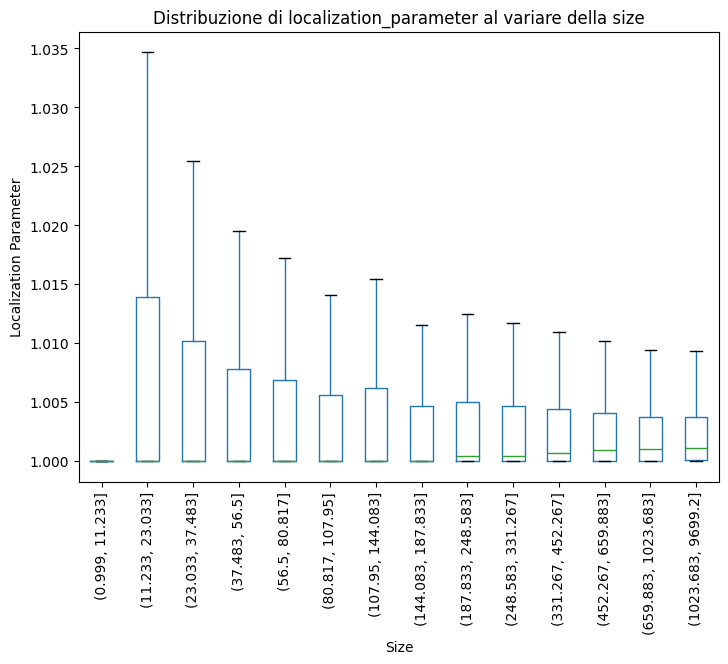

In [17]:
import matplotlib.pyplot as plt

# Creare due boxplot per la variabile 'localization_parameter' rispetto alla 'size'
fig, ax = plt.subplots(figsize=(8, 6))

# Crea i boxplot separati per le categorie di 'size'
merged_df.boxplot(column='localization_parameter', by='size', ax=ax, grid=False, showfliers=False)

# Personalizzazione del grafico
plt.title('Distribuzione di localization_parameter al variare della size')
plt.suptitle('')  # Rimuove il titolo automatico del groupby boxplot
plt.xlabel('Size')
plt.ylabel('Localization Parameter')

# Ridimensiona e ruota le etichette dell'asse x
plt.xticks(rotation=90, fontsize=10)  # Ruota di 90 gradi con dimensione del testo più piccola

plt.show()


## User behaviour
How the propension of the same user is influenced by the context.

In [3]:
from tools.to_do import *

# Raggruppiamo per 'post_id' e 'page_id' e otteniamo il timestamp minimo per ogni gruppo
posts = data.groupby(['post_id', 'page_id'])['timestamp'].min().reset_index()

# Convertiamo 'timestamp' in formato datetime
posts['timestamp'] = pd.to_datetime(posts['timestamp'])

# Creiamo una colonna 'week' che rappresenta la settimana del 'timestamp'
posts['week'] = posts['timestamp'].dt.to_period('d')

# Raggruppiamo per 'user_id' e 'post_id' per calcolare il numero di commenti per ogni post
comments = data.groupby(['user_id', 'post_id','week','page_id']).size().reset_index(name='comment_count')

# Impostiamo un limite per i commenti (se ci sono più di 5 commenti, li limitamo a 5)
comments['comment_count'] = comments['comment_count'].apply(lambda x: 10 if x > 10 else x)

/tmp/ipykernel_8666/4160589874.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['week'] = posts['timestamp'].dt.to_period('d')


In [17]:

merged_df = pd.merge(weekly_unique_users, comments, on=['page_id',  'week'], how='right')

# Filtra le righe con unique_users_count uguale a 100 o 500
upper=2000
lower=1000
size_100 = merged_df[merged_df['unique_users_count'] < lower]['user_id'].unique()

size_500 = merged_df[merged_df['unique_users_count'] > upper]['user_id'].unique()

# Trova i page_id presenti in entrambe le condizioni
pages_with_size_change = set(size_100).intersection(set(size_500))

print(pages_with_size_change)
print(len(pages_with_size_change))


{'t2_115o5k', 't2_10sx85', 't2_6hmatqbm', 't2_b9jzg', 't2_1sc09gtt', 't2_hifny', 't2_8zxtn', 't2_1g0xcxu5', 't2_6y8qx', 't2_pia6v', 't2_7ypnk7wv', 't2_n3hc7', 't2_1sn1na0', 't2_wy50a', 't2_jcgqd', 't2_6343zlul', 't2_wnbp5', 't2_aje4nu1k', 't2_fl5p9', 't2_sagw4', 't2_1i973zxx', 't2_16l8ks', 't2_1kxujr6m', 't2_81g67', 't2_js5wr', 't2_x3zm3', 't2_86773rgn', 't2_fgi40', 't2_82dfw', 't2_hm82l', 't2_t5916', 't2_a1mbyysz', 't2_mtxld', 't2_6lkzf', 't2_n1und', 't2_15ghe2', 't2_3y4km', 't2_f7vws', 't2_9thr2', 't2_2gpzgo5w', 't2_fr20i', 't2_5608rbmg', 't2_ziuud', 't2_a1asf8x4', 't2_onyqv', 't2_1j1bz5bx', 't2_4aa2i', 't2_bmnie', 't2_1jzd7zr', 't2_3e4uj', 't2_b8xom', 't2_3ufpiyik', 't2_pyw47', 't2_44txb', 't2_pzj7k', 't2_8ud6q', 't2_11ngl6ed', 't2_631admpw', 't2_2uxjebyl', 't2_4dl48', 't2_cimta259', 't2_17dcwc', 't2_ospp1', 't2_alwdp', 't2_118nzl', 't2_b79mebhl', 't2_eg4hr', 't2_d7sse', 't2_5ll4o95u', 't2_920dky4', 't2_2j0kda6t', 't2_a2wh289d', 't2_ctcx7s7k', 't2_4rp1z', 't2_eq229', 't2_6424j', 't2

In [18]:
import pandas as pd
import random
from tqdm import tqdm

# Numero di utenti da campionare
sample_size = 1000

# Seleziona un campione casuale di 1000 utenti
sampled_users = random.sample(pages_with_size_change, sample_size)

# DataFrame vuoto per memorizzare i risultati finali
selected_rows = []

# Itera sugli utenti nel campione
for user in tqdm(sampled_users):
    # Filtra le righe per l'utente
    user_df = merged_df[merged_df['user_id'] == user]

    # Separa le righe con size maggiore di 500 e con size minore di 100
    size_greater_500 = user_df[user_df['unique_users_count'] > upper]
    size_less_100 = user_df[user_df['unique_users_count'] < lower]

    # Trova il numero minimo di righe tra le due categorie
    min_rows = min(len(size_greater_500), len(size_less_100))

    # Seleziona il numero minimo di righe da entrambe le categorie
    selected_greater_500 = size_greater_500.head(min_rows)
    selected_less_100 = size_less_100.head(min_rows)

    # Unisci le righe selezionate
    selected_user_rows = pd.concat([selected_greater_500, selected_less_100])

    # Aggiungi le righe selezionate al DataFrame finale
    selected_rows.append(selected_user_rows)

# Combina tutte le righe selezionate in un unico DataFrame
final_df = pd.concat(selected_rows, ignore_index=True)


/tmp/ipykernel_8666/3161367365.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_users = random.sample(pages_with_size_change, sample_size)
100%|██████████| 1000/1000 [01:04<00:00, 15.53it/s]


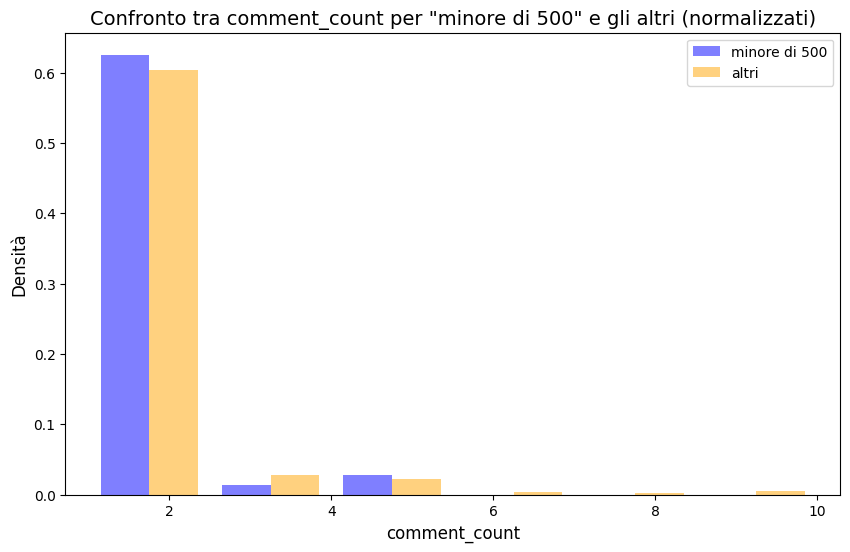

Osservato diff in media: -0.17186206896551726
P-value del test di permutazione: 0.0948
Le distribuzioni non sono significativamente diverse.
Media 'minore di 500': 1.289655172413793, Media 'altri': 1.4615172413793103
Mediana 'minore di 500': 1.0, Mediana 'altri': 1.0
'altri' ha una media maggiore.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Creazione delle distribuzioni come da codice iniziale
final_df['size'] = final_df['unique_users_count'].apply(lambda x: 'maggiore di 500' if x > 200 else 'minore di 500')

data_minore_500 = final_df[final_df['size'] == 'minore di 500']['comment_count']
data_altri = final_df[final_df['size'] != 'minore di 500']['comment_count']

# Funzione per calcolare la differenza di media tra due campioni
def calculate_diff_mean(data1, data2):
    return np.mean(data1) - np.mean(data2)

# Test di permutazione
np.random.seed(42)
observed_diff = calculate_diff_mean(data_minore_500, data_altri)
combined_data = np.concatenate([data_minore_500, data_altri])

n_permutations = 10000
permuted_diffs = []

for _ in range(n_permutations):
    np.random.shuffle(combined_data)
    permuted_data_1 = combined_data[:len(data_minore_500)]
    permuted_data_2 = combined_data[len(data_minore_500):]
    permuted_diff = calculate_diff_mean(permuted_data_1, permuted_data_2)
    permuted_diffs.append(permuted_diff)

# Calcolare il p-value
permuted_diffs = np.array(permuted_diffs)
p_value_perm = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

# Creazione dell'istogramma relativo (normalizzato)
plt.figure(figsize=(10, 6))
plt.hist([data_minore_500, data_altri], bins=6, label=['minore di 500', 'altri'], alpha=0.5, color=['blue', 'orange'], density=True)

# Etichette
plt.title('Confronto tra comment_count per "minore di 500" e gli altri (normalizzati)', fontsize=14)
plt.xlabel('comment_count', fontsize=12)
plt.ylabel('Densità', fontsize=12)

# Legenda
plt.legend()

# Mostra il grafico
plt.show()

# Risultati
print(f"Osservato diff in media: {observed_diff}")
print(f"P-value del test di permutazione: {p_value_perm}")
if p_value_perm < 0.05:
    print("Le distribuzioni sono significativamente diverse.")
else:
    print("Le distribuzioni non sono significativamente diverse.")

# Confronto delle medie e mediane
media_minore_500 = data_minore_500.mean()
media_altri = data_altri.mean()

mediana_minore_500 = data_minore_500.median()
mediana_altri = data_altri.median()

print(f"Media 'minore di 500': {media_minore_500}, Media 'altri': {media_altri}")
print(f"Mediana 'minore di 500': {mediana_minore_500}, Mediana 'altri': {mediana_altri}")

if media_minore_500 > media_altri:
    print("'minore di 500' ha una media maggiore.")
else:
    print("'altri' ha una media maggiore.")


# Age effect
Quanto il livello di attività su una pagina fino a quel momento influenza la propensione a parlare 




In [64]:
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

platform='gab'
root = '/home/jacoponudo/Documents/Size_effects/'
data = read_and_rename(platform, root)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [65]:
# Prendi solo i primi 10 utenti (unici)
unique_users = data['user_id'].drop_duplicates().head(1000)

# Filtra i dati per mantenere solo quelli relativi a questi utenti
data = data[data['user_id'].isin(unique_users)]

In [66]:
# Ordinare i dati
data = data.sort_values(by=['page_id', 'user_id', 'timestamp'])
data['interaction_len'] = data.groupby(['post_id', 'user_id'])['post_id'].transform('size')

data['posts_commented'] = 0

# Abilitare la barra di progresso per i gruppi di page_id e user_id
for (page, user), group in tqdm(data.groupby(['page_id', 'user_id']), desc="Processing users and pages"):
    post_count = 0
    previous_post_id = None  # Variabile per tracciare l'ID del post precedente
    
    # Aggiungere una barra di progresso per l'iterazione sulle righe del gruppo
    for i, row in tqdm(group.iterrows(), total=len(group), desc=f"User {user} on Page {page}", leave=False):
        # Incrementa il contatore se l'ID del post è diverso dal precedente
        if row['post_id'] != previous_post_id:
            post_count += 1
            previous_post_id = row['post_id']
        
        # Assegna il conteggio dei post commentati
        data.loc[row.name, 'posts_commented'] = post_count

# Filtro per mantenere solo gli utenti con almeno 20 commenti
data_filtered = data[data['user_id'].isin(data.groupby('user_id')['posts_commented'].max()[data.groupby('user_id')['posts_commented'].max() > 20].index)]

data_filtered = data_filtered[data_filtered['posts_commented'] <20]
# Visualizzare il risultato
print(data_filtered[['user_id','post_id','interaction_len','posts_commented']].drop_duplicates())


Processing users and pages: 100%|██████████| 1000/1000 [05:55<00:00,  2.81it/s]


        user_id   post_id  interaction_len  posts_commented
577813   100130   2229929                1                1
582408   100130   2230197                2                2
384035   100130   2440438                1                3
384050   100130   2401101                1                4
613501   100130   2465575                1                5
...         ...       ...              ...              ...
3827959   99841   9786745                1               15
4506564   99841  10004888                1               16
3530930   99841  10283507                1               17
3530948   99841  10269685                1               18
3530958   99841  10264239                1               19

[16758 rows x 4 columns]


In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Supponiamo che tu abbia già il DataFrame 'data' caricato

# Selezioniamo le colonne e rimuoviamo i duplicati
df_filtered = data_filtered[['user_id', 'post_id', 'interaction_len', 'posts_commented']].drop_duplicates()

# Un elenco di utenti unici
user_ids = df_filtered['user_id'].unique()

# Creiamo una lista per memorizzare i risultati
results = []

# Impostiamo il numero di righe e colonne per i subplot (puoi modificarlo in base al numero di utenti)
n_users = len(user_ids)


# Cicliamo su ciascun utente e tracciamo la regressione
for i, user_id in enumerate(user_ids):
    # Filtriamo i dati per l'utente corrente
    user_data = df_filtered[df_filtered['user_id'] == user_id]
    
    # Calcoliamo la regressione lineare per ottenere slope e intercept
    slope, intercept, r_value, p_value, std_err = linregress(user_data['posts_commented'], user_data['interaction_len'])
    
    # Salviamo i risultati in una lista
    results.append({'user_id': user_id, 'slope': slope, 'intercept': intercept})
    
    # Creiamo un subplot per ciascun utente
    #plt.subplot(n_rows, n_cols, i + 1)
    #sns.regplot(x='posts_commented', y='interaction_len', data=user_data, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
    # Aggiungiamo il titolo e le etichette
    #plt.title(f'Utenza {user_id}')
    #plt.xlabel('Numero di Post Commentati')
    #plt.ylabel('Lunghezza dell\'Interazione')

# Aggiungiamo una spaziatura tra i grafici
#plt.tight_layout()

# Mostriamo i grafici
#plt.show()

# Creiamo un DataFrame con i risultati
results_df = pd.DataFrame(results)

# Visualizziamo la tabella con i risultati
print(results_df)


    user_id     slope  intercept
0    100130  0.001754   1.087719
1     10039  0.012281   1.403509
2    100406 -0.010526   1.210526
3    100522 -0.263158   5.052632
4    100714  0.001754   1.087719
..      ...       ...        ...
877   99194  0.000000   1.000000
878   99553 -0.022807   1.333333
879   99760 -0.014035   1.192982
880   99763  0.010526   0.947368
881   99841 -0.012281   1.175439

[882 rows x 3 columns]


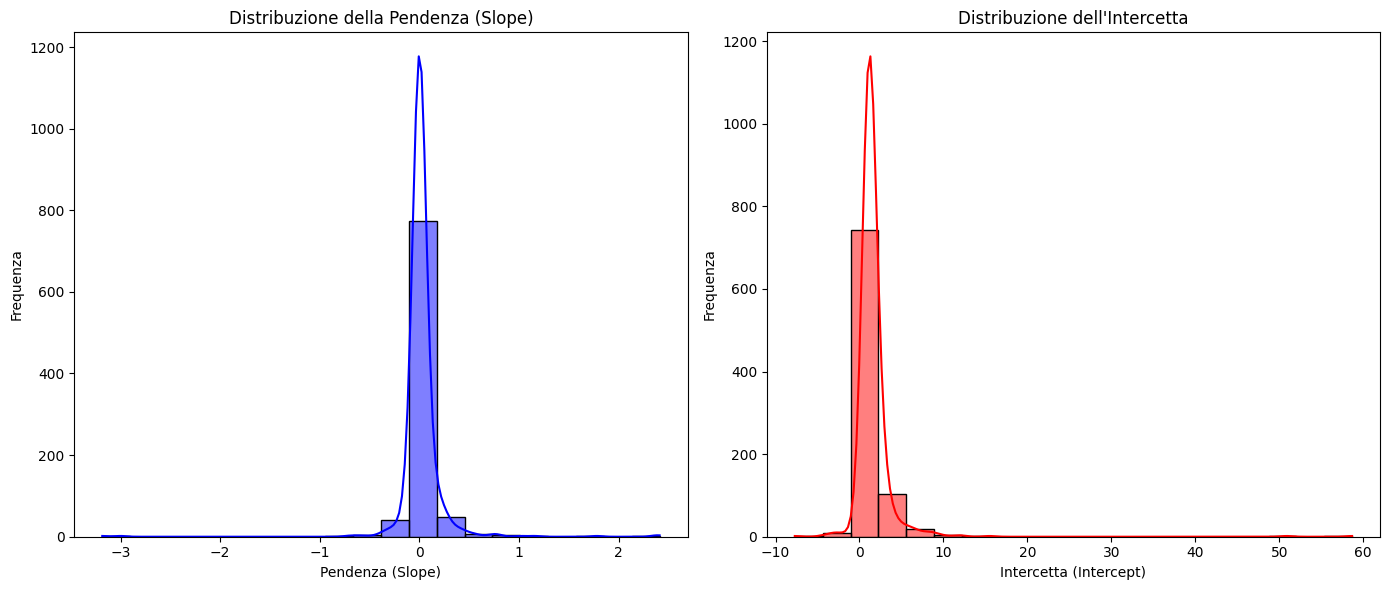

In [68]:

# Un elenco di utenti unici
user_ids = data_filtered['user_id'].unique()

# Creiamo una lista per memorizzare i risultati della regressione
slopes = []
intercepts = []

# Cicliamo su ciascun utente per calcolare la regressione
for user_id in user_ids:
    # Filtriamo i dati per l'utente corrente
    user_data = data_filtered[data_filtered['user_id'] == user_id]
    
    # Calcoliamo la regressione lineare per ottenere slope e intercept
    slope, intercept, r_value, p_value, std_err = linregress(user_data['posts_commented'], user_data['interaction_len'])
    
    # Aggiungiamo i risultati alla lista
    slopes.append(slope)
    intercepts.append(intercept)

# Creiamo due istogrammi per visualizzare le distribuzioni delle pendenze e degli intercetti
plt.figure(figsize=(14, 6))

# Istogramma della pendenza
plt.subplot(1, 2, 1)
sns.histplot(slopes, kde=True, bins=20, color='blue')
plt.title('Distribuzione della Pendenza (Slope)')
plt.xlabel('Pendenza (Slope)')
plt.ylabel('Frequenza')

# Istogramma dell'intercetta
plt.subplot(1, 2, 2)
sns.histplot(intercepts, kde=True, bins=20, color='red')
plt.title('Distribuzione dell\'Intercetta')
plt.xlabel('Intercetta (Intercept)')
plt.ylabel('Frequenza')

# Mostriamo gli istogrammi
plt.tight_layout()
plt.show()